# Markove Model with Pyspark and NumPy plotted by matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

import findspark
findspark.init(r"C:\python311\Lib\site-packages\pyspark")

In [2]:
def generate_markov_array(n_steps=100, seed=42):
    """
    Generate a synthetic Markov chain sequence as a NumPy array.
    States: 0 or 1, with simple transition probabilities.
    """
    np.random.seed(seed)
    states = [0]
    for _ in range(n_steps-1):
        if states[-1] == 0:
            states.append(np.random.choice([0,1], p=[0.7,0.3]))
        else:
            states.append(np.random.choice([0,1], p=[0.4,0.6]))
    return np.array(states)



In [3]:
def train_pyspark_markov_model(states):
    """
    Train a 'Markov-style' model in PySpark by estimating transition probabilities.
    Uses PySpark modules only.
    """
    spark = SparkSession.builder.appName("MarkovModel").getOrCreate()

    # Build transitions DataFrame
    data = [(int(states[i]), int(states[i+1])) for i in range(len(states)-1)]
    df = spark.createDataFrame(data, ["state", "next_state"])

    # Count transitions
    transition_counts = df.groupBy("state", "next_state").agg(count("*").alias("count"))

    # Compute probabilities
    total_counts = transition_counts.groupBy("state").agg(count("*").alias("total"))
    model_df = transition_counts.join(total_counts, on="state")
    model_df = model_df.withColumn("probability", col("count")/col("total"))

    # Collect to Pandas for plotting
    model_pd = model_df.toPandas()

    # Plot results
    plot_markov_model(states, model_pd)

    return model_pd



In [4]:
def plot_markov_model(states, model_pd):
    """
    Plot the Markov chain sequence and transition probabilities.
    """
    plt.figure(figsize=(10,5))

    # Plot sequence
    plt.subplot(1,2,1)
    plt.plot(states, marker='o')
    plt.title("Markov Chain Sequence")
    plt.xlabel("Step")
    plt.ylabel("State")

    # Plot transition probabilities
    plt.subplot(1,2,2)
    for state in model_pd["state"].unique():
        subset = model_pd[model_pd["state"]==state]
        plt.bar([f"{state}->{ns}" for ns in subset["next_state"]],
                subset["probability"])
    plt.title("Transition Probabilities")
    plt.ylabel("Probability")

    plt.tight_layout()
    plt.show()

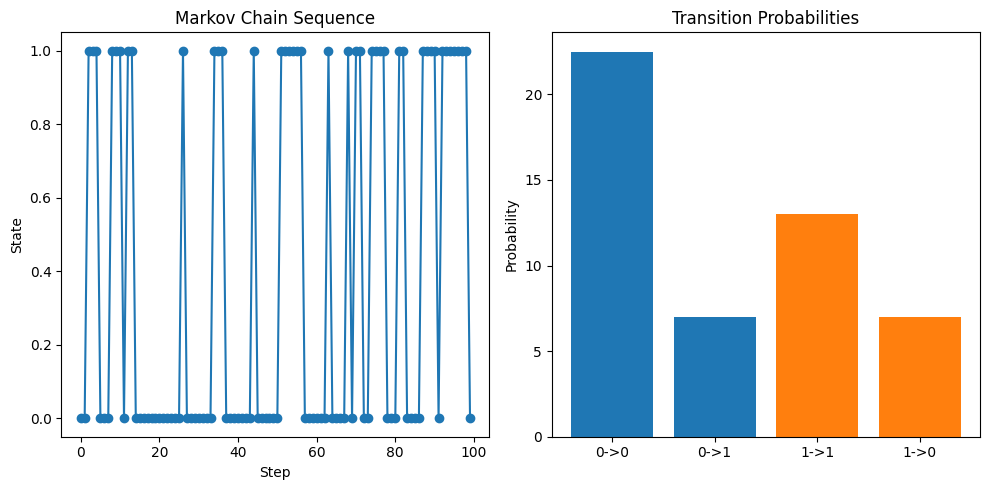

In [5]:
states = generate_markov_array()
model = train_pyspark_markov_model(states)